In [1]:
import numpy as np
import XNLdyn
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool

%matplotlib notebook

In [2]:
import warnings
warnings.filterwarnings('default')

In [3]:

## Set up the problem
PAR = XNLdyn.XNLpars()

N_local_fluences_to_calculate = 30
N_pulse_energies = 20
Nsteps_r = 100

pulse_energy_J = 3e-13# J


PAR.N_photens = 3
PAR.t0_i       = [3, 0,0]   # Arrival time on time-axis / fs
PAR.tdur_sig_i = [1,3,5]  # Rms pulse duration / fs
PAR.E_i_abs    = [848,851.2,852,] # Photon Energies of incident pulses / eV
PAR.lambda_res_Ei = (10,10,10)


PAR.I0_i =  [.4* XNLdyn.photons_per_J(PAR.E_i_abs[0])*pulse_energy_J,
             1*XNLdyn.photons_per_J(PAR.E_i_abs[1])*pulse_energy_J,
             1*XNLdyn.photons_per_J(PAR.E_i_abs[2])*pulse_energy_J]

print(*zip(PAR.E_i_abs,PAR.I0_i))


(848, 883.2324161972778) (851.2, 2199.779983949987) (852, 2197.7144628382966)


In [4]:
sim = XNLdyn.XNLsim(PAR, DEBUG=True, load_tables = False)

sim.par.I0_i

Energy 0.50 too close to others to satisfy the resonant bandwidth of 0.80
Energy 0.50 too close to others to satisfy the resonant bandwidth of 0.80
Energy 1.30 too close to others to satisfy the resonant bandwidth of 0.80
200
Starting to generate lookup tables for T between 296.0 to 100000295.0 and mu_chem between -80.0 and 25.0
Lookup tables generated.


[883.2324161972778, 2199.779983949987, 2197.7144628382966]

In [5]:
tb =  {'size': 400,
                     'chem_pot_minstep': 0.005,
                     'chem_pot_min': -80,
                     'chem_pot_max': 25,
                     'T_max': 1e8} 
N=400
temperatures = np.logspace(0, np.log10(tb['T_max']), N - 1) + 295
fermis_upper = np.logspace(np.log10(tb['chem_pot_minstep']), np.log10(tb['chem_pot_max']), int(N / 2))
fermis_lower = np.logspace(np.log10(tb['chem_pot_minstep']), np.log10(-tb['chem_pot_min']), int(N / 2))
fermis = np.concatenate((-fermis_lower[::-1], fermis_upper[1:]))

<IPython.core.display.Javascript object>


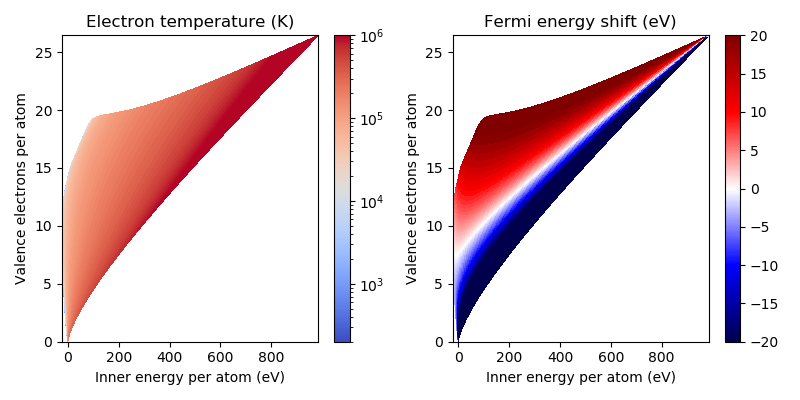

<IPython.core.display.Javascript object>


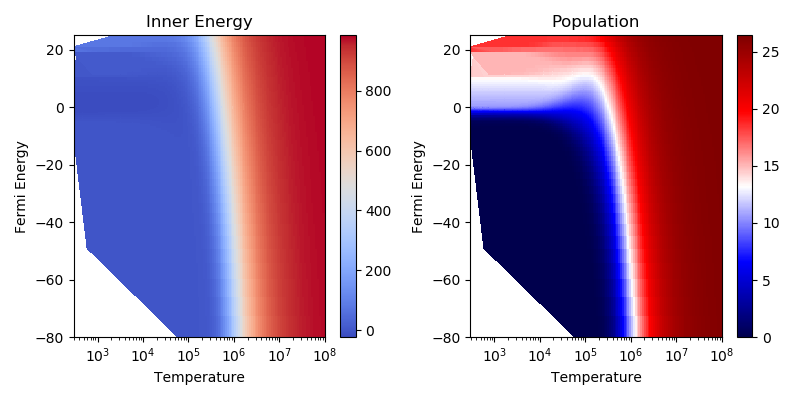

CPU times: user 560 ms, sys: 643 ms, total: 1.2 s
Wall time: 579 ms


In [6]:
%%time

PAR.FermiSolver.plot_lookup_tables()

t:  -25.0
-23.224406978633287 10.0 -> 1185.2150854671856 0.005449207399919942
Photons impinging per atom this timestep:  [2.20090838e-170 2.66411122e-015 7.14963891e-006]
Deviation from electron conservation:  0.0
Deviation from energy conservation (%):  nan
t:  -24.998112837381527
-23.22440684901598 10.00000000127824 -> 1185.2150854671856 0.005449207399919942
Photons impinging per atom this timestep:  [2.32032891e-170 2.67811294e-015 7.16314367e-006]
Deviation from electron conservation:  0.0
Deviation from energy conservation (%):  nan
t:  -24.992793562168973
-23.2244064836685 10.000000004881166 -> 1185.2150854671856 0.005449207399919942
Photons impinging per atom this timestep:  [2.69291559e-170 2.71797060e-015 7.20134095e-006]
Deviation from electron conservation:  0.0
Deviation from energy conservation (%):  inf
t:  -24.989190343253462
-23.224406236160924 10.000000007360018 -> 1185.2150854671856 0.005449207399919942
Photons impinging per atom this timestep:  [2.97868563e-170 2.745

/home/engelr/Beamtime_XFEL2018/Simulation/python/XNLdyn/XNLdyn/XNLsim.py:797: RuntimeWarning: divide by zero encountered in double_scalars
  100 * np.abs(is_new_energy - should_be_new_energy)[check_z_index] / energy_incoming[check_z_index])


 [5.39330523e-170 2.91183037e-015 7.38218709e-006]
Deviation from electron conservation:  -1.2924697071141057e-26
Deviation from energy conservation (%):  -2.29835518457046e-05
t:  -24.963967810844867
-23.224404502473973 10.000000024834186 -> 1185.2150854671856 0.005449207399919942
Photons impinging per atom this timestep:  [6.03226349e-170 2.94434913e-015 7.41176109e-006]
Deviation from electron conservation:  2.261821987449685e-26
Deviation from energy conservation (%):  -2.576290892749273e-05
t:  -24.963967810844867
-23.22440450335165 10.000000024834453 -> 1185.2150854671856 0.005449207399919942
Photons impinging per atom this timestep:  [6.03226349e-170 2.94434913e-015 7.41176109e-006]
Deviation from electron conservation:  -3.715850407953054e-26
Deviation from energy conservation (%):  5.0836820677290684e-05
t:  -24.94676124773536
-23.224403321080853 10.000000036900776 -> 1185.2150854671856 0.005449207399919942
Photons impinging per atom this timestep:  [9.75849372e-170 3.08823107

Photons impinging per atom this timestep:  [8.17253918e-119 3.06453924e-010 4.74435009e-004]
Deviation from electron conservation:  -4.632211430296955e-23
Deviation from energy conservation (%):  0.0
t:  -20.26205128426637
-23.223967911730316 10.000053799100758 -> 1185.2150854671856 0.005449207399919942
Photons impinging per atom this timestep:  [1.20966719e-117 3.97805815e-010 5.21154951e-004]
Deviation from electron conservation:  9.926167350636332e-24
Deviation from energy conservation (%):  2.0744042818231386e-08
t:  -20.117606839821924
-23.223942468293544 10.000060966985956 -> 1185.2150854671856 0.005449207399919942
Photons impinging per atom this timestep:  [3.44664796e-116 5.50044002e-010 5.85636771e-004]
Deviation from electron conservation:  7.610061635487855e-23
Deviation from energy conservation (%):  1.8311622291168787e-08
t:  -20.117606839821924
-23.223945400267738 10.00006216381463 -> 1185.2150854671856 0.005449207399919942
Photons impinging per atom this timestep:  [3.44

Photons impinging per atom this timestep:  [5.38099775e-62 7.22039771e-05 4.07537207e-02]
Deviation from electron conservation:  -8.893845946170154e-21
Deviation from energy conservation (%):  0.0
t:  -13.762051284266365
-23.206837367963654 10.00622083766658 -> 1471.8119524293088 0.014389770590071294
Photons impinging per atom this timestep:  [3.75809963e-61 8.62228229e-05 4.34419456e-02]
Deviation from electron conservation:  -1.1858461261560205e-20
Deviation from energy conservation (%):  1.7339764861395568e-10
t:  -13.61760683982192
-23.205351104690443 10.006783330685252 -> 1586.549665034066 0.018627040993067112
Photons impinging per atom this timestep:  [4.18740581e-60 1.07409455e-04 4.70176119e-02]
Deviation from electron conservation:  -3.3881317890172014e-21
Deviation from energy conservation (%):  0.0
t:  -13.61760683982192
-23.205954966146702 10.006829283829024 -> 1586.549665034066 0.018627040993067112
Photons impinging per atom this timestep:  [4.18740581e-60 1.07409455e-04 4

-22.92909313794258 10.08592810414471 -> 5045.8101621159185 0.3471340270562564
Photons impinging per atom this timestep:  [3.57193220e-27 7.93637001e-02 5.06931348e-01]
Deviation from electron conservation:  -4.743384504624082e-20
Deviation from energy conservation (%):  8.740825083811865e-12
t:  -8.027606839821917
-22.911711832961227 10.089948341546334 -> 5509.008287974172 0.4072818205794704
Photons impinging per atom this timestep:  [1.51068090e-26 8.92047506e-02 5.28719022e-01]
Deviation from electron conservation:  2.710505431213761e-20
Deviation from energy conservation (%):  8.164706005300659e-12
t:  -7.377606839821918
-22.815997918653796 10.110326353951328 -> 6135.403018963727 0.4806321825326165
Photons impinging per atom this timestep:  [1.58645131e-23 1.55591453e-01 6.45951821e-01]
Deviation from electron conservation:  -1.8973538018496328e-19
Deviation from energy conservation (%):  6.022104770275083e-12
t:  -7.262051284266363
-22.791009721355948 10.11384479422036 -> 6411.3899

Photons impinging per atom this timestep:  [2.16171376e-05 2.60915535e+00 1.78248236e+00]
Deviation from electron conservation:  2.168404344971009e-18
Deviation from energy conservation (%):  0.0
t:  -1.6576068398219186
-20.36178936654416 10.281043091924793 -> 18778.108475346697 2.138973390246548
Photons impinging per atom this timestep:  [7.50582281e-05 2.74743713e+00 1.81593064e+00]
Deviation from electron conservation:  2.0599841277224584e-18
Deviation from energy conservation (%):  0.0
t:  -1.5276068398219187
-20.240871834074994 10.278078957007859 -> 19212.734046880956 2.169825943075722
Photons impinging per atom this timestep:  [1.36360631e-04 2.81137263e+00 1.83103182e+00]
Deviation from electron conservation:  -2.168404344971009e-19
Deviation from energy conservation (%):  5.548665731394935e-13
t:  -0.8776068398219186
-19.60580104284778 10.267914597035185 -> 21380.291264219617 2.376004042749827
Photons impinging per atom this timestep:  [2.09434791e-03 3.06647221e+00 1.88918859e

-9.861881005262658 9.988896581226081 -> 47717.35104124961 3.6976779949291085
Photons impinging per atom this timestep:  [1.10232359 0.9967479  1.26059616]
Deviation from electron conservation:  8.239936510889834e-18
Deviation from energy conservation (%):  0.0
t:  4.842393160178081
-9.227223442870283 9.982537440230152 -> 49179.34515974102 3.756024337603151
Photons impinging per atom this timestep:  [0.70623876 0.86988592 1.20030521]
Deviation from electron conservation:  -3.469446951953614e-18
Deviation from energy conservation (%):  1.6561177349018647e-13
t:  4.972393160178081
-8.90274647243754 9.980710064925313 -> 49941.291111239465 3.7747787277688474
Photons impinging per atom this timestep:  [0.55114187 0.81035912 1.1700628 ]
Deviation from electron conservation:  1.3010426069826053e-18
Deviation from energy conservation (%):  4.123651259445939e-14
t:  5.622393160178081
-7.3021640197649695 9.970508469410097 -> 53496.17513890943 3.889157641736574
Photons impinging per atom this time

Photons impinging per atom this timestep:  [1.98991754e-13 4.77871630e-03 1.84347525e-01]
Deviation from electron conservation:  -8.673617379884035e-18
Deviation from energy conservation (%):  0.0
t:  10.937948715733638
6.231188684572359 9.924294604625018 -> 79422.42474406664 4.291552378447477
Photons impinging per atom this timestep:  [8.00511539e-14 4.15567942e-03 1.75305845e-01]
Deviation from electron conservation:  -6.071532165918825e-18
Deviation from energy conservation (%):  7.96029484931293e-14
t:  11.082393160178082
6.5961970793223035 9.923319844755904 -> 80063.83435284004 4.289389605553964
Photons impinging per atom this timestep:  [2.51697069e-14 3.48256637e-03 1.64501191e-01]
Deviation from electron conservation:  -9.107298248878237e-18
Deviation from energy conservation (%):  3.984021923062751e-14
t:  11.082393160178082
6.595039540066649 9.923310359993312 -> 80027.54366397014 4.298565732789768
Photons impinging per atom this timestep:  [2.51697069e-14 3.48256637e-03 1.645

Photons impinging per atom this timestep:  [5.78114543e-40 7.99320128e-07 8.05498492e-03]
Deviation from electron conservation:  -6.071532165918825e-18
Deviation from energy conservation (%):  1.6735684332540916e-13
t:  16.672393160178085
20.378719857701732 9.889932709965871 -> 102062.94797365619 4.049661794193355
Photons impinging per atom this timestep:  [9.85743326e-41 6.28840067e-07 7.38855883e-03]
Deviation from electron conservation:  4.336808689942018e-18
Deviation from energy conservation (%):  0.0
t:  17.322393160178084
21.935492317366922 9.886457934682687 -> 104414.30012277118 3.9927432891946637
Photons impinging per atom this timestep:  [1.10260498e-44 1.84248880e-07 4.74931538e-03]
Deviation from electron conservation:  1.734723475976807e-18
Deviation from energy conservation (%):  0.0
t:  17.43794871573364
22.212439391377828 9.885846876769111 -> 104800.86964986936 3.9881972653541595
Photons impinging per atom this timestep:  [2.09290278e-45 1.47397739e-07 4.38270216e-03]
D

34.6251524197378 9.860177619703945 -> 122692.33232014762 3.4310158783708857
Photons impinging per atom this timestep:  [4.04546985e-85 9.59756392e-13 5.95200417e-05]
Deviation from electron conservation:  -8.239936510889834e-18
Deviation from energy conservation (%):  3.5629679456962474e-13
t:  22.78239316017809
34.61919481215777 9.860179523876047 -> 122675.12257355906 3.432599158513966
Photons impinging per atom this timestep:  [4.04546985e-85 9.59756392e-13 5.95200417e-05]
Deviation from electron conservation:  -1.1709383462843448e-17
Deviation from energy conservation (%):  3.5629665117686434e-13
t:  23.04239316017809
35.20699018261075 9.859047192113696 -> 123507.08228503939 3.3983752273769596
Photons impinging per atom this timestep:  [2.28312624e-87 4.95103045e-13 4.69003061e-05]
Deviation from electron conservation:  -1.1709383462843448e-17
Deviation from energy conservation (%):  0.0
t:  23.17239316017809
35.49922169551172 9.858493241009993 -> 123919.22433671427 3.38381790325698

48.302321891811495 9.835959153400443 -> 141535.63078723868 2.5899674172014215
Photons impinging per atom this timestep:  [3.47967934e-147 1.52289384e-020 9.26501931e-008]
Deviation from electron conservation:  2.6020852139652106e-18
Deviation from energy conservation (%):  7.586434945034509e-13
t:  29.137948715733646
48.547506677776795 9.835562030056405 -> 141888.36591414237 2.5683728355103597
Photons impinging per atom this timestep:  [1.70884311e-148 1.04837079e-020 8.09973165e-008]
Deviation from electron conservation:  -1.734723475976807e-18
Deviation from energy conservation (%):  0.0
t:  29.282393160178092
48.8539674935123 9.835069713134734 -> 142285.08138419586 2.5523803174412762
Photons impinging per atom this timestep:  [3.87704475e-150 6.56017457e-021 6.84186979e-008]
Deviation from electron conservation:  6.5052130349130266e-18
Deviation from energy conservation (%):  0.0
t:  29.282393160178092
48.85443437914739 9.835071298770856 -> 142285.08138419586 2.5523803174412762
Phot

Photons impinging per atom this timestep:  [2.30403012e-215 6.55848537e-029 9.01850481e-011]
Deviation from electron conservation:  0.0
Deviation from energy conservation (%):  0.0
t:  34.74239316017809
60.129946674749434 9.81840620847256 -> 157592.24067222513 1.6965920518348128
Photons impinging per atom this timestep:  [6.20762245e-219 2.41294045e-029 6.29219306e-011]
Deviation from electron conservation:  1.734723475976807e-18
Deviation from energy conservation (%):  0.0
t:  34.87239316017809
60.390493719335666 9.818057419395213 -> 157944.44505265876 1.6763334424476284
Photons impinging per atom this timestep:  [9.93423666e-221 1.45946897e-029 5.25043654e-011]
Deviation from electron conservation:  -3.903127820947816e-18
Deviation from energy conservation (%):  0.0
t:  35.52239316017809
61.69102878676475 9.81632225180546 -> 159685.52375434717 1.5740578176631175
Photons impinging per atom this timestep:  [8.09257781e-230 1.14869187e-030 2.10260910e-011]
Deviation from electron conser

Photons impinging per atom this timestep:  [2.06978220e-313 9.58891712e-041 4.94905529e-015]
Deviation from electron conservation:  -9.974659986866641e-18
Deviation from energy conservation (%):  0.0
t:  40.98239316017808
72.30000246420164 9.803549935743355 -> 174188.09158272116 0.6312530499773175
Photons impinging per atom this timestep:  [2.06978220e-313 9.58891712e-041 4.94905529e-015]
Deviation from electron conservation:  1.3010426069826053e-18
Deviation from energy conservation (%):  0.0
t:  41.242393160178075
72.79187771516781 9.803014047881502 -> 174795.6839949228 0.6004835072487253
Photons impinging per atom this timestep:  [1.02897076e-317 2.92389493e-041 3.22724173e-015]
Deviation from electron conservation:  -5.637851296924623e-18
Deviation from energy conservation (%):  0.0
t:  41.37239316017808
73.03622315417796 9.80275346607365 -> 175129.874582933 0.5775422249124631
Photons impinging per atom this timestep:  [7.07551411e-320 1.61003233e-041 2.60342887e-015]
Deviation fro

Photons impinging per atom this timestep:  [0.00000000e+00 1.28222505e-54 5.01132299e-20]
Deviation from electron conservation:  1.0842021724855044e-17
Deviation from energy conservation (%):  9.126917458057549e-13
t:  47.48239316017806
84.23682265586851 9.792082724944473 -> 190675.16357362794 -0.5332290440981922
Photons impinging per atom this timestep:  [0.00000000e+00 1.28222505e-54 5.01132299e-20]
Deviation from electron conservation:  -6.071532165918825e-18
Deviation from energy conservation (%):  1.825382584742263e-12
t:  47.74239316017806
84.69841593003082 9.791696716621711 -> 191345.89493661388 -0.5874943877400369
Photons impinging per atom this timestep:  [0.00000000e+00 3.24045207e-55 3.05424083e-20]
Deviation from electron conservation:  -8.673617379884035e-19
Deviation from energy conservation (%):  9.150709141934552e-13
t:  47.87239316017806
84.92796330018244 9.79150986335532 -> 191660.58820596634 -0.6096315897905811
Photons impinging per atom this timestep:  [0.00000000e+

93.87906482472859 9.784984970737044 -> 204384.383278515 -1.5853097355546026
Photons impinging per atom this timestep:  [0.00000000e+00 3.51465252e-68 6.57056815e-25]
Deviation from electron conservation:  -4.336808689942018e-18
Deviation from energy conservation (%):  0.0
t:  53.72239316017805
94.89069099320626 9.784306917959363 -> 205853.05882472315 -1.7028918247021636
Photons impinging per atom this timestep:  [0.00000000e+00 7.43079206e-70 1.63929797e-25]
Deviation from electron conservation:  -1.3010426069826053e-18
Deviation from energy conservation (%):  0.0
t:  53.8379487157336
94.91361466612716 9.784189837532441 -> 205903.34893154618 -1.7093788185305527
Photons impinging per atom this timestep:  [0.00000000e+00 3.72520401e-70 1.27849574e-25]
Deviation from electron conservation:  -4.336808689942018e-19
Deviation from energy conservation (%):  9.725715424766185e-13
t:  53.98239316017805
95.16383914430645 9.784044366107816 -> 206273.30000652053 -1.7400499003347818
Photons impingi

Photons impinging per atom this timestep:  [0.00000000e+00 1.79168144e-85 3.91074184e-31]
Deviation from electron conservation:  6.938893903907228e-18
Deviation from energy conservation (%):  2.0571906812178355e-12
t:  59.57239316017804
104.47095502555011 9.779436589426638 -> 219974.69895719885 -2.858222878908663
Photons impinging per atom this timestep:  [0.00000000e+00 7.58511966e-86 2.86993287e-31]
Deviation from electron conservation:  -8.673617379884035e-18
Deviation from energy conservation (%):  1.029928536974475e-12
t:  60.22239316017804
105.49244876005457 9.779023394665813 -> 221518.40701328177 -2.989361229208839
Photons impinging per atom this timestep:  [0.00000000e+00 1.00285471e-87 6.04687441e-32]
Deviation from electron conservation:  2.6020852139652106e-18
Deviation from energy conservation (%):  0.0
t:  60.33794871573359
105.67046988603275 9.778952018058988 -> 221782.22851857933 -3.0108921793129184
Photons impinging per atom this timestep:  [0.00000000e+00 4.62496179e-8

113.84093252650399 9.776458366404452 -> 234309.60637915242 -4.087071796141089
Photons impinging per atom this timestep:  [0.00000000e+000 2.60043492e-104 6.46400700e-038]
Deviation from electron conservation:  9.540979117872439e-18
Deviation from energy conservation (%):  1.0947372767094787e-12
t:  65.68239316017802
113.83901528968582 9.776458969992676 -> 234333.85579085627 -4.093138940605996
Photons impinging per atom this timestep:  [0.00000000e+000 2.60043492e-104 6.46400700e-038]
Deviation from electron conservation:  -3.469446951953614e-18
Deviation from energy conservation (%):  2.1894734859474264e-12
t:  65.94239316017803
114.22602488427651 9.77637314288465 -> 234911.67531356035 -4.140264026088204
Photons impinging per atom this timestep:  [0.00000000e+000 3.88458783e-105 3.26023903e-038]
Deviation from electron conservation:  -7.806255641895632e-18
Deviation from energy conservation (%):  0.0
t:  66.07239316017802
114.4183770770714 9.776333916559972 -> 235196.39175593678 -4.163

121.93790396150314 9.775332332264052 -> 247164.67569764671 -5.227971687222407
Photons impinging per atom this timestep:  [0.00000000e+000 8.78218925e-123 1.44804570e-044]
Deviation from electron conservation:  2.168404344971009e-18
Deviation from energy conservation (%):  0.0
t:  71.922393160178
122.85013220601023 9.775288951982091 -> 248658.85304607826 -5.3649422513264255
Photons impinging per atom this timestep:  [0.00000000e+000 4.98769096e-125 2.25075952e-045]
Deviation from electron conservation:  -4.336808689942018e-19
Deviation from energy conservation (%):  1.165103463642718e-12
t:  72.03794871573356
123.00941093001502 9.775282706608962 -> 248931.58379575508 -5.391180688714826
Photons impinging per atom this timestep:  [0.00000000e+000 1.97937912e-125 1.61374792e-045]
Deviation from electron conservation:  -6.071532165918825e-18
Deviation from energy conservation (%):  1.1664484763174863e-12
t:  72.18239316017801
123.21170581766306 9.775276152258815 -> 249257.29519792527 -5.420

Deviation from electron conservation:  -3.903127820947816e-18
Deviation from energy conservation (%):  1.2335511820664973e-12
t:  77.772393160178
130.8211023160622 9.775631464766079 -> 261990.74504856428 -6.6004792157469865
Photons impinging per atom this timestep:  [0.00000000e+000 3.70785843e-146 5.57146740e-053]
Deviation from electron conservation:  -3.686287386450715e-18
Deviation from energy conservation (%):  0.0
t:  78.42239316017799
131.67891409379007 9.77574499215129 -> 263435.3292124488 -6.7337409589733
Photons impinging per atom this timestep:  [0.00000000e+000 1.31686955e-148 7.31342234e-054]
Deviation from electron conservation:  0.0
Deviation from energy conservation (%):  2.4863703205284274e-12
t:  78.53794871573355
131.83010348174585 9.775766371303364 -> 263674.6495364498 -6.754049225643115
Photons impinging per atom this timestep:  [0.00000000e+000 4.80758954e-149 5.08837511e-054]
Deviation from electron conservation:  -6.7220534694101275e-18
Deviation from energy con

<IPython.core.display.Javascript object>


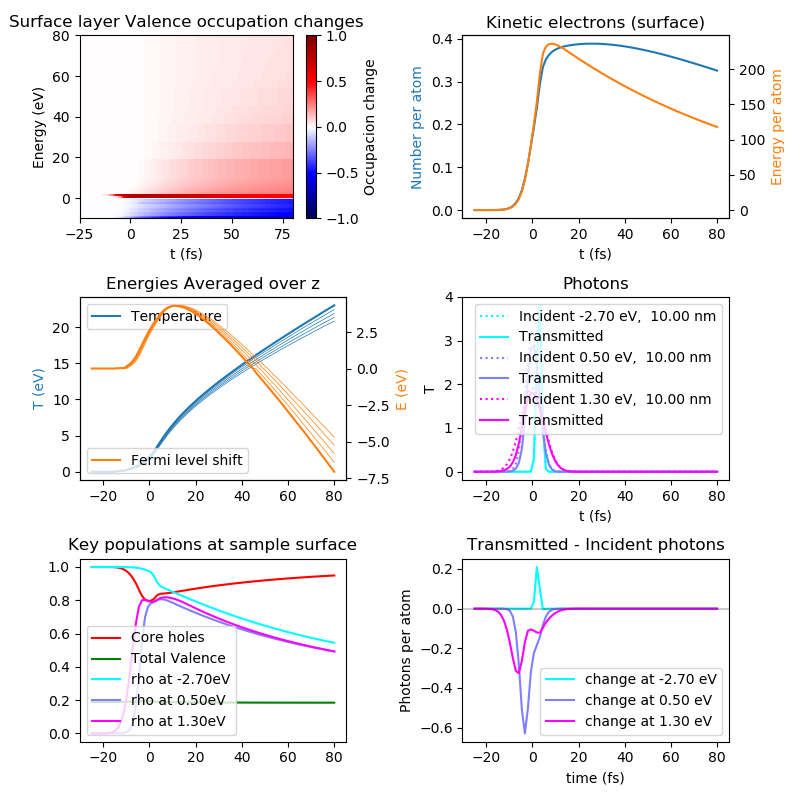

Transmission:  [104.56922483  83.1687729   85.96515432]  %
CPU times: user 31.5 s, sys: 1.46 s, total: 33 s
Wall time: 31.7 s


In [7]:
%%time
sim_options = dict(t_span=[-25, 80],
                   method='RK45',
                   rtol=1e-2, atol=1e-8, 
                   plot = True,
                   return_full_solution = True)

incident, transmitted, sol = sim.run(**sim_options)

print('Transmission: ', 100 * transmitted/incident, ' %')


<IPython.core.display.Javascript object>


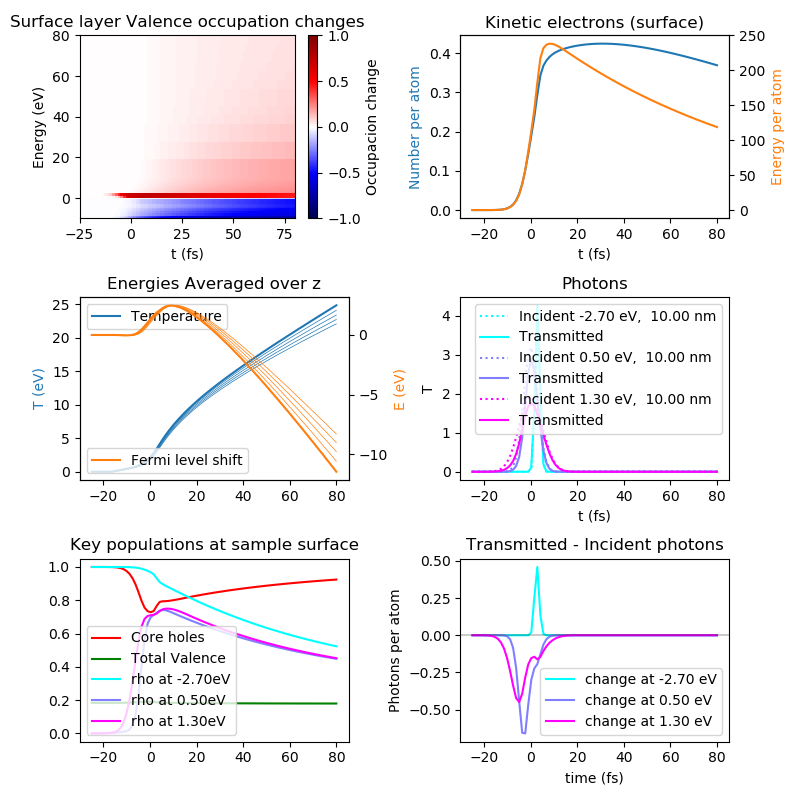

In [8]:
sim.plot_results(sol, sol.photon_densities)

<IPython.core.display.Javascript object>


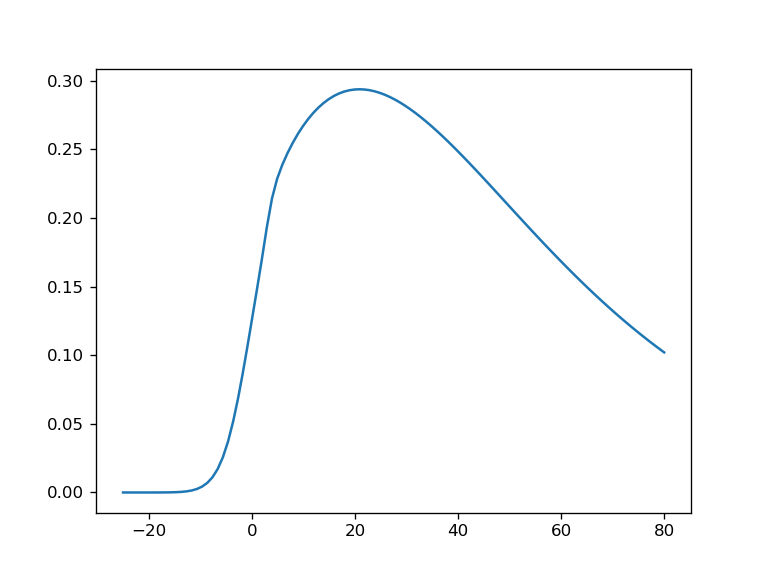

In [15]:
plt.figure()
plt.plot(sol.t, sol.R_free[0])

<IPython.core.display.Javascript object>


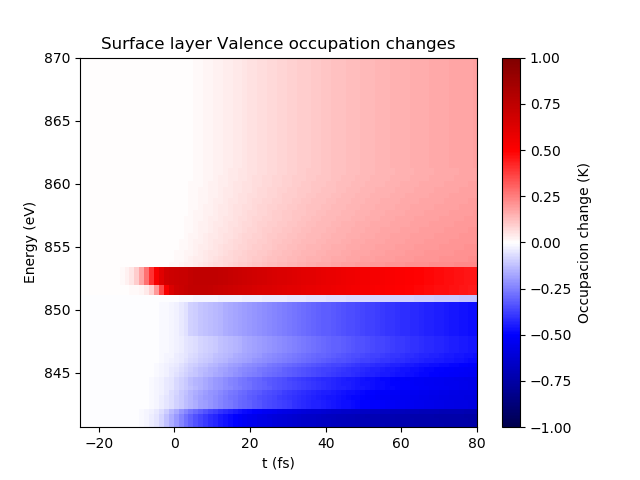

(840.7, 870)

In [13]:
plt.figure()
plt.pcolormesh(sol.t, PAR.E_j +PAR.E_f,
               (sol.rho_j[0]-np.outer(PAR.rho_j_0,np.ones(sol.t.shape)))/np.outer(PAR.m_j,np.ones(sol.t.shape)),
               cmap = plt.cm.seismic, vmin = -1, vmax = 1, shading = 'nearest')#
plt.colorbar(label = 'Occupacion change (K)')
plt.xlabel('t (fs)')
plt.ylabel('Energy (eV)')
plt.title('Surface layer Valence occupation changes')
plt.ylim(None, 870)

<IPython.core.display.Javascript object>


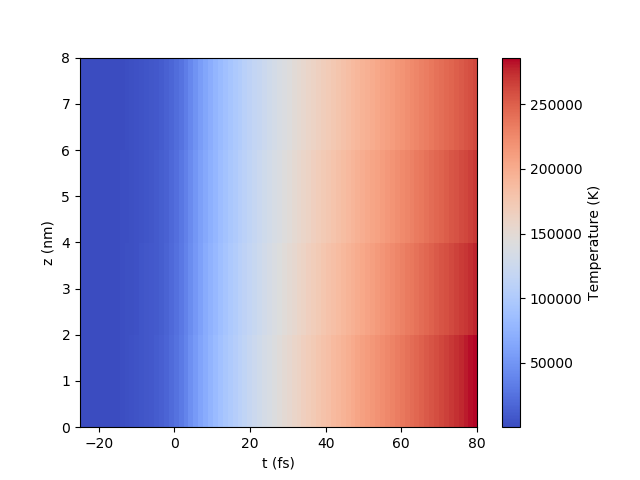

Text(0, 0.5, 'z (nm)')

In [14]:
plt.figure()
plt.pcolormesh(sol.t, PAR.zaxis, sol.temperatures.T, cmap = plt.cm.coolwarm)
plt.colorbar(label = 'Temperature (K)')
plt.xlabel('t (fs)')
plt.ylabel('z (nm)')

<IPython.core.display.Javascript object>


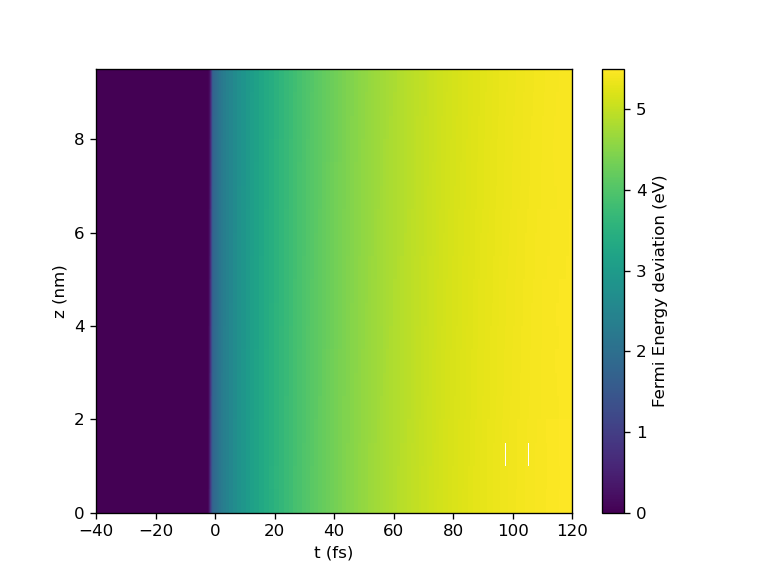

/tmp/ipykernel_186854/203480434.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(sol.t, PAR.zaxis, sol.fermi_energies.T)


Text(0, 0.5, 'z (nm)')

In [35]:
plt.figure()
plt.pcolormesh(sol.t, PAR.zaxis, sol.fermi_energies.T)
plt.colorbar(label = 'Fermi Energy deviation (eV)')
plt.xlabel('t (fs)')
plt.ylabel('z (nm)')

<IPython.core.display.Javascript object>


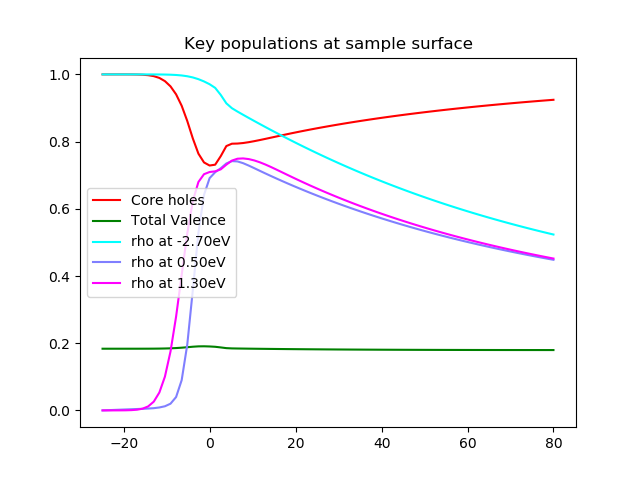

In [15]:
plt.figure()
plt.title('Key populations at sample surface')
plt.plot(sol.t,sol.core[0]/PAR.M_core, c='red', label = 'Core holes')
plt.plot(sol.t,(sol.R_VB[0])/PAR.M_VB, c='green',label = 'Total Valence')
cols = plt.cm.cool(np.linspace(0,1,PAR.N_photens))
for iE,E in enumerate(PAR.E_i):
    plt.plot(sol.t,sol.rho_j[0,PAR.resonant,:][iE].T/PAR.m_j[PAR.resonant][iE],c = cols[iE], label = f'rho at {E:.2f}eV')
plt.legend()


<IPython.core.display.Javascript object>


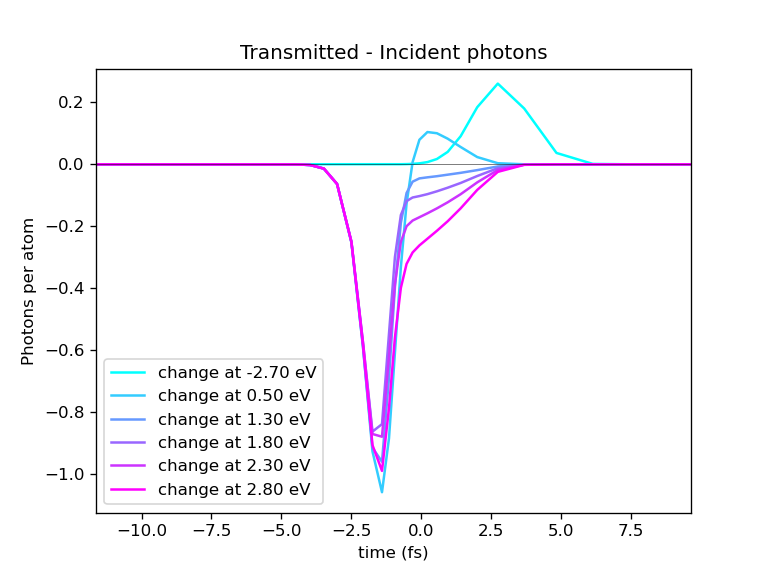

Text(0, 0.5, 'Photons per atom')

In [13]:
T = (sol.photon_densities[-1]-sol.photon_densities[0])#/np.max(sol.photon_densities[0],1)

plt.figure()
for iE,E in enumerate(PAR.E_i):
    plt.plot(sol.t,T[iE],c = cols[iE], label = f'change at {E:.2f} eV')
plt.axhline(c='k', lw = 0.3)
plt.legend()

plt.title('Transmitted - Incident photons')
plt.xlabel('time (fs)')
plt.ylabel('Photons per atom')

In [24]:
PAR.M_core

2

<IPython.core.display.Javascript object>


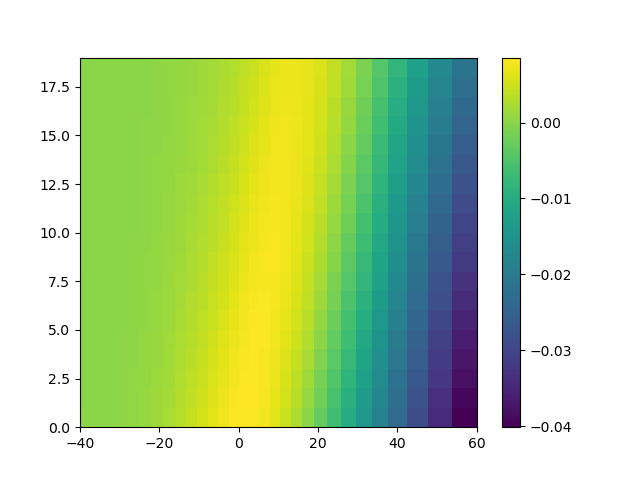

/tmp/ipykernel_121456/52012410.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(sol.t, PAR.zaxis, (sol.R_VB-PAR.R_VB_0)/PAR.M_VB)


In [34]:
plt.figure()
plt.pcolormesh(sol.t, PAR.zaxis, (sol.R_VB-PAR.R_VB_0)/PAR.M_VB)
plt.colorbar()

In [21]:
sol.t.shape

(40,)

In [77]:
def make_valence_energy_axis(self, N_j: int, min=-6, finemax=10, max=50):
        """
        Creates an energy axis for the valence band, namely
            self.E_j
        and its edgepoints
            self.enax_j_edges
        Energies are relative to the fermi-level. 3/4 of all points fall into the range (min, finemax)
        Makes sure that the energies E_i correspond to a point in E_j and
        drops the closest points to keep the number N_j.
        :param N_j:
        :param min:
        :param finemax:
        :param max:
        :return:
        """
        N_j_fine = int(N_j * 3 / 4)
        N_j_coarse = int(N_j - N_j_fine)

        def fill_biggest_gap(pointlist):
            """
            This function takes a list of points and appends a point in the middle of the biggest gap
            """
            pointlist = np.array(np.sort(pointlist))
            gaps = pointlist[1:]-pointlist[:-1]
            biggest_gap_index = np.argsort(gaps)[-1]
            biggest_gap = gaps[biggest_gap_index]
            list_before = pointlist[:biggest_gap_index+1]
            new_value = pointlist[biggest_gap_index] + 0.5*biggest_gap
            list_after = pointlist[biggest_gap_index+1:]
            return np.concatenate((list_before, [new_value,], list_after))
        
        # The energies E_i and 0 must be in the axis
        enax_j_fine = [min, 0, finemax]+list(self.E_i[self.E_i<=finemax])
        # Fill up the gaps
        while len(enax_j_fine)<N_j_fine:
            enax_j_fine = fill_biggest_gap(enax_j_fine)
        
        dE = np.mean(enax_j_fine[1:]-enax_j_fine[:-1])
        #The same for the coarse part
        enax_j_coarse = [finemax+dE, max]+list(self.E_i[self.E_i>finemax])
        while len(enax_j_coarse)<N_j_coarse:
            enax_j_coarse = fill_biggest_gap(enax_j_coarse)
            
        enax_j = np.concatenate((enax_j_fine, enax_j_coarse))

        if not len(enax_j) == N_j:
            warnings.warn(
                'Energy Axis turned out longer or shorter than planned. What went wrong?')
            self.N_j = len(enax_j)
            
        def edgepoints(middles):
            """ Opposite of midpoints """
            edges = np.empty(middles.shape[0] + 1)
            edges[1:-1] = (middles[1:] + middles[:-1]) / 2
            edges[0] = middles[0] - (middles[1] - middles[0]) / 2
            edges[-1] = middles[-1] + (middles[-1] - middles[-2]) / 2
            return edges

        return enax_j, edgepoints(enax_j)

In [55]:
sim.plot_derivatives?

<IPython.core.display.Javascript object>


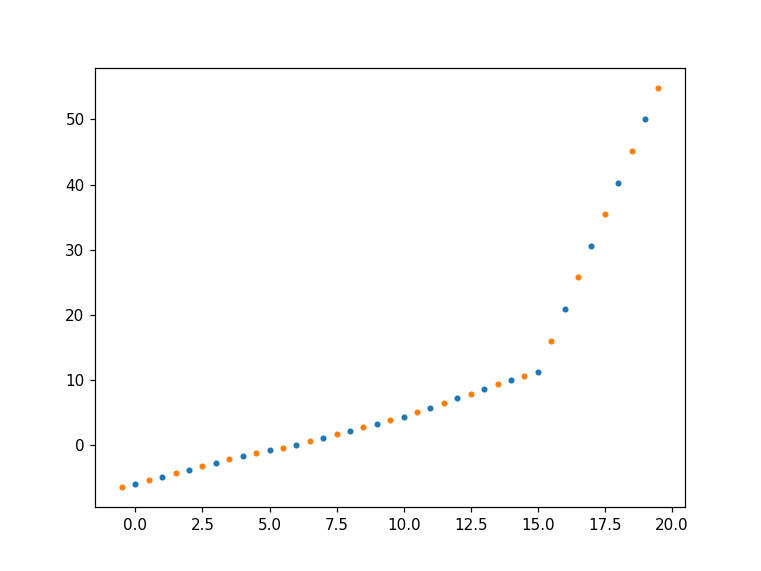

In [82]:
enax, enax_edges = make_valence_energy_axis(PAR, 20, min=-6, finemax=10, max=50)
plt.figure()
plt.plot(np.arange(len(enax)),enax,'.')
plt.plot(np.arange(len(enax_edges))-0.5,enax_edges,'.')